# ConvCNP for Interpolating Temperature from Sensor Readings and ERA5

The first small-scale experiment to use a ConvCNP to interpolate sensor temperature readings, with topography, ERA5, and sensor layers.

In [28]:
import sys
from pathlib import Path

# Make project root importable
ROOT = Path().resolve().parents[1]
sys.path.append(str(ROOT))

In [29]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
%autoreload 2
from src.utils.variables.var_names import *
from src.utils.variables.coord_names import *
from src.data_processing.conversions.scalar_conversions import *
from src.config.env_loader import get_env_var

from src.data_processing.station_processor import ProcessStations
from src.data_processing.topology_processor import ProcessTopography
from src.data_processing.era5_processor import ProcessERA5

In [31]:
# DeepSensor imports
import deepsensor.torch
from deepsensor.train.train import train_epoch, set_gpu_default_device
from deepsensor.data.loader import TaskLoader
from deepsensor.data.processor import DataProcessor
from deepsensor.model.convnp import ConvNP

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from mpl_toolkits.basemap import Basemap

In [32]:
# setup variables for experiment
var = TEMPERATURE
years = [2010, 2011, 2012, 2013, 2014]

train_years = [2010] #[2010, 2011, 2012, 2013]
validation_years = [2014]

# GPU settings
use_gpu = True
if use_gpu:
    set_gpu_default_device()

# visualisations of data
DEBUG_PLOTS = True

In [33]:
# load datasets
station_processor = ProcessStations()
topography_processor = ProcessTopography()
era5_processor = ProcessERA5()


In [34]:
# topography and ERA5 datasets are loaded as simple xarray datasets
topography_ds = topography_processor.load_ds(standardise_var_names=True, standardise_coord_names=True)
era5_ds = era5_processor.load_ds(mode="surface", years=years, standardise_var_names=True, standardise_coord_names=True)

In [35]:
# clean up the ERA5 data:
era5_da = era5_processor.get_variable(era5_ds, var) # set variable to process - e.g. "temperature"
era5_da = kelvin_to_celsius(era5_da)

### Crop data for proof-of-concept

In [36]:
crop_left = 168
crop_right = 174
crop_top = -40
crop_bottom = -46

In [37]:
era5_da = era5_da.sel(lat=slice(crop_top, crop_bottom), lon=slice(crop_left, crop_right))
topography_ds = topography_ds.sel(lat=slice(crop_bottom, crop_top), lon=slice(crop_left, crop_right))

### Cleanup & validation of ERA5 Data

In [38]:
# coarsen ERA5
era5_da_coarsen = era5_da.coarsen(lat=5, lon=5, boundary='trim').mean()

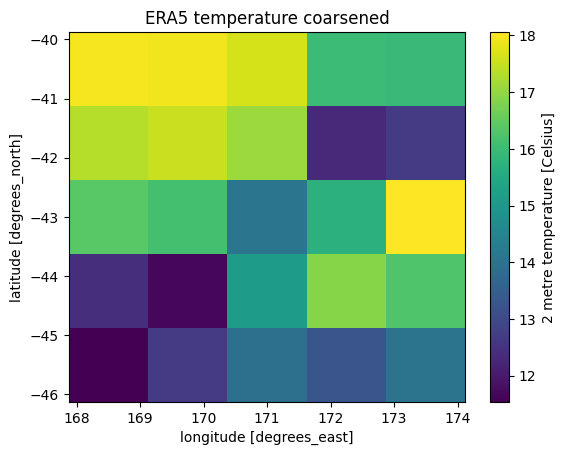

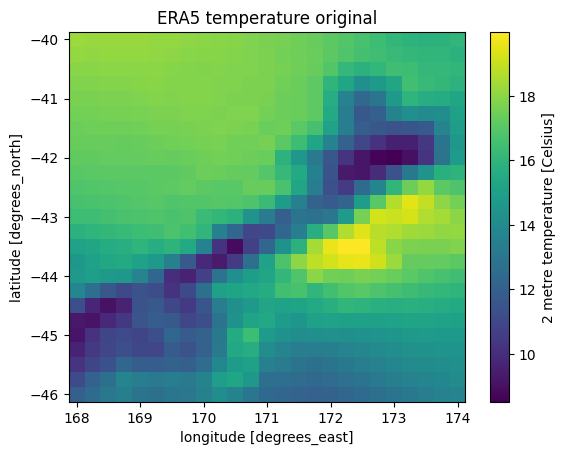

In [39]:
if DEBUG_PLOTS:
    # visual check of correctness
    era5_da_coarsen.sel(time="2010-01-01T18:00").plot()
    plt.title(f"ERA5 {var} coarsened")
    plt.show()

    era5_da.sel(time="2010-01-01T18:00").plot()
    plt.title(f"ERA5 {var} original")
    plt.show()

### Cleanup & Validation of Topographical Data

In [40]:
# Compute the topographic position index (TPI) from elevation data
ds_tpi = topography_processor.compute_tpi(topography_ds)

# coarsen the elevation data
topo_coarse = topography_ds.coarsen(lat=100, lon=100, boundary='trim').mean()[ELEVATION]

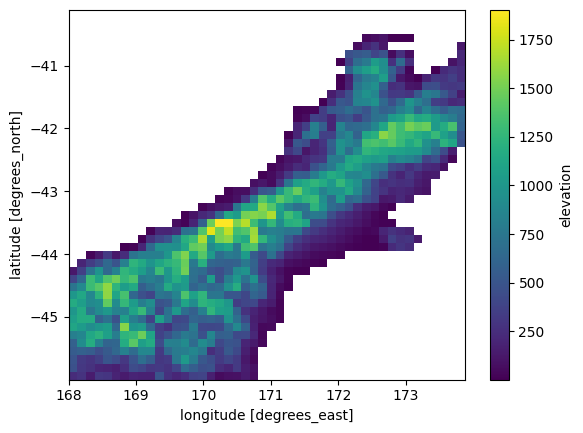

In [41]:
if DEBUG_PLOTS:
    topo_coarse.plot()

In [42]:
# fill elevation Nans with 0's (ocean areas)
topography_ds = topography_ds.fillna(0)
topo_coarse = topo_coarse.fillna(0)

### Load the stations
Not all stations load temperature across all timestamps.

Desired data format:

| lat | long | time | temperature |
|:---:|:----:|:----:|:-----------:|
| float | float | timestamp | float |
| float | float | timestamp | float |

In [43]:
# load the stations with the variable of interest between the start and end years
stations_df = station_processor.load_df(vars=[var], year_start=2010, year_end=2014)

/home/lennoxc/niwa/convcnp-assim-nz/src/data_processing/station_processor.py:157: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'time' ('time',) The recommendation is to set join explicitly for this case.
  ds_comb = xr.concat([first, *station_iter], dim="station")


In [44]:
stations_df.head()
stations_reset = stations_df.reset_index()
stations_reset.drop(columns=['station'], inplace=True)

In [45]:
# resample to six-hourly frequency to match ERA5 timestamps
stations_resample = stations_reset.groupby(['lat', 'lon']).resample("6h", on='time').mean()[['temperature']]
stations_resample = stations_resample.reset_index().set_index(['time', 'lat', 'lon']).sort_index()

/tmp/ipykernel_4278/3879327337.py:2: FutureWarning: DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stations_resample = stations_reset.groupby(['lat', 'lon']).resample("6h", on='time').mean()[['temperature']]


In [46]:
# slice to smaller area for proof-of-concept
stations_resample = stations_resample[(stations_resample.index.get_level_values('lat') > crop_bottom) & (stations_resample.index.get_level_values('lat') < crop_top) &
                                      (stations_resample.index.get_level_values('lon') > crop_left) & (stations_resample.index.get_level_values('lon') < crop_right)]


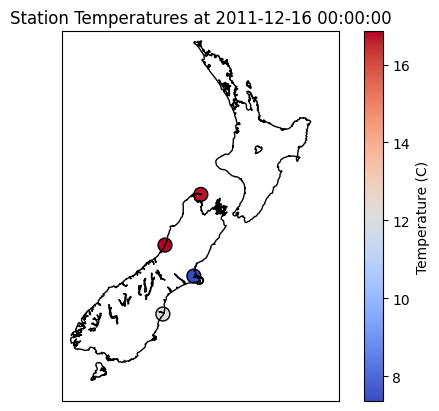

In [47]:
# plot temperature across all locations using temperature colormap at a single time step
# plot on a map of NZ using basemap
time_step = "2011-12-16 00:00:00"
m = Basemap(projection='merc', llcrnrlat=-48, urcrnrlat=-34, llcrnrlon=166, urcrnrlon=180, resolution='i')
m.drawcoastlines()
m.drawcountries()
x, y = m(stations_resample.reset_index().loc[stations_resample.reset_index()['time'] == time_step]['lon'].values,
           stations_resample.reset_index().loc[stations_resample.reset_index()['time'] == time_step]['lat'].values)
sc = m.scatter(x, y,
               c=stations_resample.reset_index().loc[stations_resample.reset_index()['time'] == time_step]['temperature'].values,
               cmap='coolwarm', marker='o', edgecolor='k', s=100)
plt.colorbar(sc, label='Temperature (C)')
plt.title(f'Station Temperatures at {time_step}')
plt.show()

### Ensure compatibility of layers

In [48]:
# slice the ERA5 data to match the topography extent
era5_da = era5_da.sel(lat=slice(topo_coarse[LATITUDE].max(), topo_coarse[LATITUDE].min()), lon=slice(topo_coarse[LONGITUDE].min(), topo_coarse[LONGITUDE].max()))

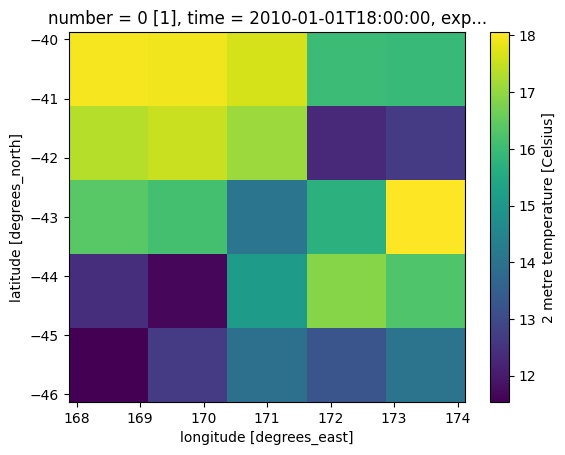

In [49]:
era5_da_coarsen.sel(time="2010-01-01T18:00").plot()

### Normalisation and Preprocessing

In [50]:
data_processor = DataProcessor(x1_name=LATITUDE, x1_map=(era5_da[LATITUDE].min(), era5_da[LATITUDE].max()), x2_name=LONGITUDE, x2_map=(era5_da[LONGITUDE].min(), era5_da[LONGITUDE].max()))

In [51]:
era5_processed, station_processed = data_processor([era5_da_coarsen, stations_resample])

In [52]:
aux_highres_processed, aux_processed = data_processor([topography_ds, topo_coarse], method='min_max')

In [53]:
print(data_processor)

DataProcessor with normalisation params:
{'coords': {'time': {'name': 'time'},
            'x1': {'map': (-45.75, -40.25), 'name': 'lat'},
            'x2': {'map': (168.25, 173.75), 'name': 'lon'}},
 'elevation': {'method': 'min_max',
               'params': {'max': 3655.506591796875, 'min': -3.802651882171631}},
 'temperature': {'method': 'mean_std',
                 'params': {'mean': 11.279519081115723,
                            'std': 4.451348304748535}},
 'tpi_ws0.025': {'method': 'min_max',
                 'params': {'max': 1340.01416015625,
                            'min': -873.2457885742188}},
 'tpi_ws0.05': {'method': 'min_max',
                'params': {'max': 1791.067138671875,
                           'min': -941.2045288085938}},
 'tpi_ws0.1': {'method': 'min_max',
               'params': {'max': 1314.4798583984375,
                          'min': -910.5855712890625}}}


In [54]:
from deepsensor.data.utils import construct_x1x2_ds

x1x2_ds = construct_x1x2_ds(aux_processed)
aux_processed['x1_arr'] = x1x2_ds['x1_arr']
aux_processed['x2_arr'] = x1x2_ds['x2_arr']
aux_processed

<xarray.DataArray 'elevation' (x1: 46, x2: 46)> Size: 8kB
array([[-0.8692661 , -0.84410405, -0.91702163, ..., -0.99792165,
        -0.99792165, -0.99792165],
       [-0.73827374, -0.83090395, -0.8492451 , ..., -0.99792165,
        -0.99792165, -0.99792165],
       [-0.72905827, -0.8202595 , -0.8393349 , ..., -0.99792165,
        -0.99792165, -0.99792165],
       ...,
       [-0.99792165, -0.99792165, -0.99792165, ..., -0.99792165,
        -0.99792165, -0.99792165],
       [-0.99792165, -0.99792165, -0.99792165, ..., -0.99792165,
        -0.99792165, -0.99792165],
       [-0.99792165, -0.99792165, -0.99792165, ..., -0.99792165,
        -0.99792165, -0.99792165]], shape=(46, 46), dtype=float32)
Coordinates:
  * x1       (x1) float32 184B -0.03382 -0.01055 0.01273 ... 0.9669 0.9902 1.013
  * x2       (x2) float32 184B -0.03394 -0.01066 0.01261 ... 0.9668 0.9901 1.013
    x1_arr   (x1, x2) float32 8kB -0.03382 -0.03382 -0.03382 ... 1.013 1.013
    x2_arr   (x1, x2) float32 8kB -0.03394 -0.01066 0.01261 ... 0.9901 1.013

In [55]:
# this doesn't use any stations in the context set.
# this should be updated for data assimilation experiments later.
task_loader = TaskLoader(context=[era5_processed, aux_processed], target=station_processed, aux_at_targets=aux_highres_processed)

In [56]:
model = ConvNP(data_processor, task_loader, unet_channels=(32,)*3, likelihood="gnp")

dim_yc inferred from TaskLoader: (1, 1)
dim_yt inferred from TaskLoader: 1
dim_aux_t inferred from TaskLoader: 4
Setting aux_t_mlp_layers: (64, 64, 64)
internal_density inferred from TaskLoader: 42
encoder_scales inferred from TaskLoader: [np.float32(0.11363636), np.float32(0.0116363615)]
decoder_scale inferred from TaskLoader: 0.023809523809523808


In [57]:
task_loader.load_dask()

In [58]:
train_dates = era5_da.sel(time=slice("2010-01-01", "2011-12-31")).time.values
val_dates = era5_da.sel(time=slice("2012-01-01", "2012-06-30")).time.values

In [59]:
from tqdm import tqdm
train_tasks = []
for date in tqdm(train_dates[::2]):
    task = task_loader(date, context_sampling="all", target_sampling="all")
    train_tasks.append(task)

val_tasks = []
for date in tqdm(val_dates):
    task = task_loader(date, context_sampling="all", target_sampling="all")
    val_tasks.append(task)

100%|██████████| 728/728 [00:03<00:00, 235.04it/s]


In [60]:
train_tasks[0]

time: Timestamp/2010-01-01 00:00:00
ops: []
X_c: [('ndarray/float32/(1, 5)', 'ndarray/float32/(1, 5)'), ('ndarray/float32/(1, 46)', 'ndarray/float32/(1, 46)')]
Y_c: ['ndarray/float32/(1, 5, 5)', 'ndarray/float32/(1, 46, 46)']
X_t: ['ndarray/float32/(2, 5)']
Y_t: ['ndarray/float32/(1, 5)']
Y_t_aux: ndarray/float32/(4, 5)

/home/lennoxc/niwa/convcnp-assim-nz/venv/lib/python3.12/site-packages/lab/types.py:204: DeprecationWarning: numpy.core is deprecated and has been renamed to numpy._core. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numerictypes.
  for name in np.core.numerictypes.__all__ + ["bool"]:


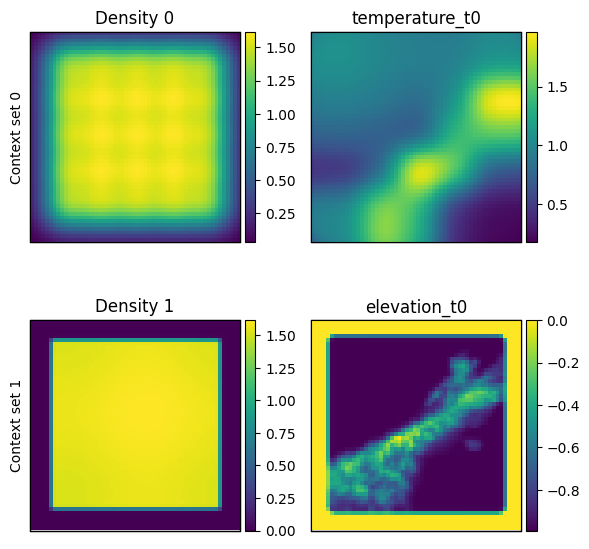

In [61]:
fig = deepsensor.plot.context_encoding(model, train_tasks[0], task_loader)

# Understanding the ConvNP Architecture

In [62]:
assert str(type(model)) == "<class 'deepsensor.model.convnp.ConvNP'>"
assert str(type(model.model)) == "<class 'neuralprocesses.torch.Model'>"
assert str(type(model.model.encoder)) == "<class 'neuralprocesses.torch.FunctionalCoder'>"
assert str(type(model.model.decoder)) == "<class 'neuralprocesses.torch.Chain'>"

The ConvNP class has an encoder-decoder architecture, which encodes inputs onto the internal grid, with a latent representation. The full source for a ConvGNP can be found here: https://github.com/wesselb/neuralprocesses/blob/main/neuralprocesses/architectures/convgnp.py

## Encoder:
At a high level, the encoder is of class 'neuralprocesses.torch.FunctionalCoder'. This has a `.coder` field, which contains the Chain object.

Context Encoding:
- The SetConv encoder maps the context sets (ERA5, sensors, topology) to the ConvNP's internal grid.
- Place a Gaussian kernel at each (x, y) location (in space). Weight these by the observation values (e.g. temperature).
- Place a Gaussian kernel at each (x, y) location (in space). Weight by presence of input to create a density map.

A suitible input stucture could be:
- Context set 0: Sensor obs (with their own density channel). Density will be sparse.
- Context set 1: Complete sets of weather observations (ERA5, satellite etc). Density will be full.
- Context set 2: Stationary context data (sun incedence, topography etc). Density will be full.

One density channel per context set is created.

In [63]:
for i in range(len(model.model.encoder.coder.links)):
    print(f"Link {i}: {type(model.model.encoder.coder.links[i])}")
    print(model.model.encoder.coder.links[i])
    print("--------------------")

Link 0: <class 'neuralprocesses.torch.AssertParallel'>
AssertParallel()
--------------------
Link 1: <class 'neuralprocesses.torch.PrependDensityChannel'>
PrependDensityChannel()
--------------------
Link 2: <class 'neuralprocesses.torch.Parallel'>
Parallel(
    SetConv(),
    SetConv(),
)
--------------------
Link 3: <class 'neuralprocesses.torch.DivideByFirstChannel'>
DivideByFirstChannel()
--------------------
Link 4: <class 'neuralprocesses.torch.Concatenate'>
Concatenate()
--------------------
Link 5: <class 'neuralprocesses.torch.nn._LambdaModule'>
_LambdaModule()
--------------------
Link 6: <class 'neuralprocesses.torch.DeterministicLikelihood'>
DeterministicLikelihood()
--------------------


## Decoder

In [64]:
for i in range(len(model.model.decoder.links)):
    print(f"Link {i}: {type(model.model.decoder.links[i])}")
    print(model.model.decoder.links[i])
    print("--------------------")

Link 0: <class 'neuralprocesses.torch.UNet'>
UNet(
  (before_turn_layers): ModuleList(
    (0): Conv2d(4, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1-2): 2 x Sequential(
      (0): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
  )
  (after_turn_layers): ModuleList(
    (0): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Sequential(
      (0): Upsample(scale_factor=2.0, mode='bilinear')
      (1): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
    (2): Sequential(
      (0): Upsample(scale_factor=2.0, mode='bilinear')
      (1): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
  )
  (final_linear): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
)
--------------------
Link 1: <class 'neuralprocesses.torch.RepeatForAggregateInputs'>
RepeatForAggregateInputs(
  (coder): Chain(
      SetConv(),
      _LambdaModule

In [65]:
%autoreload 2
import src.learning.model_diagnostics as model_diagnostics

In [66]:
model_diagnostics.count_model_parameters(model.model)

Total number of parameters: 198629


198629

In [67]:
#find_model_structure(model.model)
model_diagnostics.model_parameters_by_layer(model.model)

Layer 0 (<class 'neuralprocesses.torch.FunctionalCoder'>):
    Layer 0 (<class 'neuralprocesses.torch.Discretisation'>):
        Layer (<class 'neuralprocesses.torch.Discretisation'>): 0 parameters
    Layer 1 (<class 'neuralprocesses.torch.Chain'>):
        Layer 0 (<class 'torch.nn.modules.container.ModuleList'>):
            Layer 0 (<class 'neuralprocesses.torch.AssertParallel'>):
                Layer (<class 'neuralprocesses.torch.AssertParallel'>): 0 parameters
            Layer 1 (<class 'neuralprocesses.torch.PrependDensityChannel'>):
                Layer (<class 'neuralprocesses.torch.PrependDensityChannel'>): 0 parameters
            Layer 2 (<class 'neuralprocesses.torch.Parallel'>):
                Layer 0 (<class 'torch.nn.modules.container.ModuleList'>):
                    Layer 0 (<class 'neuralprocesses.torch.SetConv'>):
                        Layer (<class 'neuralprocesses.torch.SetConv'>): 1 parameters
                    Layer 1 (<class 'neuralprocesses.torch.Set

In [68]:
model_diagnostics.model_dimensions_by_layer(model.model)

Layer 0 (<class 'neuralprocesses.torch.FunctionalCoder'>):
    Layer 0 (<class 'neuralprocesses.torch.Discretisation'>):
        Layer (<class 'neuralprocesses.torch.Discretisation'>):
    Layer 1 (<class 'neuralprocesses.torch.Chain'>):
        Layer 0 (<class 'torch.nn.modules.container.ModuleList'>):
            Layer 0 (<class 'neuralprocesses.torch.AssertParallel'>):
                Layer (<class 'neuralprocesses.torch.AssertParallel'>):
            Layer 1 (<class 'neuralprocesses.torch.PrependDensityChannel'>):
                Layer (<class 'neuralprocesses.torch.PrependDensityChannel'>):
            Layer 2 (<class 'neuralprocesses.torch.Parallel'>):
                Layer 0 (<class 'torch.nn.modules.container.ModuleList'>):
                    Layer 0 (<class 'neuralprocesses.torch.SetConv'>):
                        Layer (<class 'neuralprocesses.torch.SetConv'>):
                            Parameter: log_scale, Shape: torch.Size([])
                    Layer 1 (<class 'neura

In [69]:
deepsensor.model.nps.compute_encoding_tensor(model, train_tasks[0]).shape

(1, 4, 56, 56)

In [70]:
model.config

{'dim_x': 2,
 'dim_yc': (1, 1),
 'dim_yt': 1,
 'dim_aux_t': 4,
 'dim_lv': 0,
 'conv_arch': 'unet',
 'unet_channels': (32, 32, 32),
 'unet_resize_convs': True,
 'unet_resize_conv_interp_method': 'bilinear',
 'aux_t_mlp_layers': (64, 64, 64),
 'likelihood': 'lowrank',
 'unet_kernels': 5,
 'internal_density': 42,
 'encoder_scales': [np.float32(0.11363636), np.float32(0.0116363615)],
 'encoder_scales_learnable': False,
 'decoder_scale': 0.023809523809523808,
 'decoder_scale_learnable': False,
 'num_basis_functions': 64,
 'epsilon': 0.01}

### Setting up for Model Training

In [71]:
import lab as B
def compute_val_loss(model, val_tasks):
    val_losses = []
    for task in val_tasks:
        val_losses.append(B.to_numpy(model.loss_fn(task, normalise=True)))
    return np.mean(val_losses)

In [72]:
import torch
import os

In [92]:
from tqdm import tqdm

n_epochs = 75
train_losses = []
val_losses = []

output_model = False

val_loss_best = np.inf

for epoch in tqdm(range(n_epochs)):
    batch_losses = train_epoch(model, train_tasks, batch_size=1)
    train_loss = np.mean(batch_losses)
    train_losses.append(train_loss)

    with torch.no_grad():
        val_loss = compute_val_loss(model, val_tasks)
    val_losses.append(val_loss)

    if val_loss < val_loss_best:
        val_loss_best = val_loss
        if output_model:
            folder = os.path.join(get_env_var("OUTPUT_HOME"), "models", "downscaling", "temperature", "convcnp")
            if not os.path.exists(folder): os.makedirs(folder)
            torch.save(model.model.state_dict(), folder + f"model.pt")

    torch.cuda.empty_cache()

    print(f"Epoch {epoch} train_loss: {train_loss:.2f}, val_loss: {val_loss:.2f}")

  0%|          | 0/75 [00:00<?, ?it/s]

  1%|▏         | 1/75 [00:48<59:40, 48.39s/it]

Epoch 0 train_loss: 0.48, val_loss: 0.56


  3%|▎         | 2/75 [01:36<58:50, 48.36s/it]

Epoch 1 train_loss: 0.47, val_loss: 0.60


  4%|▍         | 3/75 [02:25<58:00, 48.35s/it]

Epoch 2 train_loss: 0.46, val_loss: 0.58


  5%|▌         | 4/75 [03:13<57:12, 48.35s/it]

Epoch 3 train_loss: 0.45, val_loss: 0.55


  7%|▋         | 5/75 [04:01<56:27, 48.40s/it]

Epoch 4 train_loss: 0.44, val_loss: 0.54


  8%|▊         | 6/75 [04:50<55:39, 48.40s/it]

Epoch 5 train_loss: 0.43, val_loss: 0.58


  9%|▉         | 7/75 [05:38<54:51, 48.40s/it]

Epoch 6 train_loss: 0.43, val_loss: 0.56


 11%|█         | 8/75 [06:26<53:59, 48.34s/it]

Epoch 7 train_loss: 0.41, val_loss: 0.57


 12%|█▏        | 9/75 [07:15<53:07, 48.30s/it]

Epoch 8 train_loss: 0.40, val_loss: 0.55


 13%|█▎        | 10/75 [08:03<52:18, 48.29s/it]

Epoch 9 train_loss: 0.40, val_loss: 0.65


 15%|█▍        | 11/75 [08:51<51:27, 48.24s/it]

Epoch 10 train_loss: 0.40, val_loss: 0.58


 16%|█▌        | 12/75 [09:39<50:42, 48.29s/it]

Epoch 11 train_loss: 0.39, val_loss: 0.57


 17%|█▋        | 13/75 [10:28<50:03, 48.44s/it]

Epoch 12 train_loss: 0.39, val_loss: 0.62


 19%|█▊        | 14/75 [11:17<49:16, 48.47s/it]

Epoch 13 train_loss: 0.38, val_loss: 0.55


 20%|██        | 15/75 [12:05<48:30, 48.50s/it]

Epoch 14 train_loss: 0.38, val_loss: 0.55


 21%|██▏       | 16/75 [12:54<47:40, 48.48s/it]

Epoch 15 train_loss: 0.37, val_loss: 0.60


 23%|██▎       | 17/75 [13:42<46:46, 48.38s/it]

Epoch 16 train_loss: 0.37, val_loss: 0.57


 24%|██▍       | 18/75 [14:30<45:53, 48.30s/it]

Epoch 17 train_loss: 0.37, val_loss: 0.56


 25%|██▌       | 19/75 [15:18<45:03, 48.27s/it]

Epoch 18 train_loss: 0.36, val_loss: 0.51


 27%|██▋       | 20/75 [16:07<44:18, 48.34s/it]

Epoch 19 train_loss: 0.36, val_loss: 0.52


 28%|██▊       | 21/75 [16:55<43:30, 48.34s/it]

Epoch 20 train_loss: 0.35, val_loss: 0.56


 29%|██▉       | 22/75 [17:44<42:47, 48.45s/it]

Epoch 21 train_loss: 0.35, val_loss: 0.57


 31%|███       | 23/75 [18:32<41:58, 48.43s/it]

Epoch 22 train_loss: 0.34, val_loss: 0.62


 32%|███▏      | 24/75 [19:20<41:05, 48.34s/it]

Epoch 23 train_loss: 0.34, val_loss: 0.55


 33%|███▎      | 25/75 [20:08<40:12, 48.26s/it]

Epoch 24 train_loss: 0.34, val_loss: 0.58


 35%|███▍      | 26/75 [20:57<39:24, 48.26s/it]

Epoch 25 train_loss: 0.34, val_loss: 0.58


 36%|███▌      | 27/75 [21:45<38:40, 48.34s/it]

Epoch 26 train_loss: 0.33, val_loss: 0.55


 37%|███▋      | 28/75 [22:33<37:50, 48.30s/it]

Epoch 27 train_loss: 0.33, val_loss: 0.57


 39%|███▊      | 29/75 [23:21<36:59, 48.25s/it]

Epoch 28 train_loss: 0.33, val_loss: 0.56


 40%|████      | 30/75 [24:10<36:08, 48.19s/it]

Epoch 29 train_loss: 0.33, val_loss: 0.56


 41%|████▏     | 31/75 [24:58<35:30, 48.42s/it]

Epoch 30 train_loss: 0.32, val_loss: 0.53


 43%|████▎     | 32/75 [25:47<34:41, 48.41s/it]

Epoch 31 train_loss: 0.32, val_loss: 0.55


 44%|████▍     | 33/75 [26:36<33:56, 48.49s/it]

Epoch 32 train_loss: 0.32, val_loss: 0.72


 45%|████▌     | 34/75 [27:24<33:10, 48.55s/it]

Epoch 33 train_loss: 0.32, val_loss: 0.56


 47%|████▋     | 35/75 [28:13<32:20, 48.50s/it]

Epoch 34 train_loss: 0.31, val_loss: 0.59


 48%|████▊     | 36/75 [29:01<31:30, 48.47s/it]

Epoch 35 train_loss: 0.31, val_loss: 0.55


 49%|████▉     | 37/75 [29:49<30:41, 48.47s/it]

Epoch 36 train_loss: 0.30, val_loss: 0.62


 51%|█████     | 38/75 [30:38<29:53, 48.47s/it]

Epoch 37 train_loss: 0.30, val_loss: 0.57


 52%|█████▏    | 39/75 [31:27<29:06, 48.50s/it]

Epoch 38 train_loss: 0.30, val_loss: 0.57


 53%|█████▎    | 40/75 [32:15<28:17, 48.51s/it]

Epoch 39 train_loss: 0.30, val_loss: 0.57


 55%|█████▍    | 41/75 [33:04<27:31, 48.56s/it]

Epoch 40 train_loss: 0.30, val_loss: 0.56


 56%|█████▌    | 42/75 [33:52<26:42, 48.56s/it]

Epoch 41 train_loss: 0.29, val_loss: 0.62


 57%|█████▋    | 43/75 [34:41<25:52, 48.53s/it]

Epoch 42 train_loss: 0.30, val_loss: 0.56


 59%|█████▊    | 44/75 [35:29<25:04, 48.53s/it]

Epoch 43 train_loss: 0.28, val_loss: 0.61


 60%|██████    | 45/75 [36:18<24:15, 48.53s/it]

Epoch 44 train_loss: 0.28, val_loss: 0.66


 61%|██████▏   | 46/75 [37:06<23:27, 48.52s/it]

Epoch 45 train_loss: 0.28, val_loss: 0.58


 63%|██████▎   | 47/75 [37:55<22:38, 48.52s/it]

Epoch 46 train_loss: 0.28, val_loss: 0.56


 64%|██████▍   | 48/75 [38:43<21:49, 48.51s/it]

Epoch 47 train_loss: 0.28, val_loss: 0.57


 65%|██████▌   | 49/75 [39:32<21:01, 48.50s/it]

Epoch 48 train_loss: 0.28, val_loss: 0.62


 67%|██████▋   | 50/75 [40:21<20:14, 48.57s/it]

Epoch 49 train_loss: 0.27, val_loss: 0.54


 68%|██████▊   | 51/75 [41:09<19:27, 48.64s/it]

Epoch 50 train_loss: 0.27, val_loss: 0.54


 69%|██████▉   | 52/75 [41:58<18:39, 48.66s/it]

Epoch 51 train_loss: 0.27, val_loss: 0.56


 71%|███████   | 53/75 [42:47<17:49, 48.61s/it]

Epoch 52 train_loss: 0.27, val_loss: 0.57


 72%|███████▏  | 54/75 [43:35<17:01, 48.65s/it]

Epoch 53 train_loss: 0.27, val_loss: 0.59


 73%|███████▎  | 55/75 [44:24<16:11, 48.60s/it]

Epoch 54 train_loss: 0.26, val_loss: 0.71


 75%|███████▍  | 56/75 [45:12<15:22, 48.55s/it]

Epoch 55 train_loss: 0.26, val_loss: 0.54


 76%|███████▌  | 57/75 [46:01<14:33, 48.52s/it]

Epoch 56 train_loss: 0.26, val_loss: 0.65


 77%|███████▋  | 58/75 [46:49<13:44, 48.49s/it]

Epoch 57 train_loss: 0.26, val_loss: 0.62


 79%|███████▊  | 59/75 [47:38<12:56, 48.52s/it]

Epoch 58 train_loss: 0.25, val_loss: 0.67


 80%|████████  | 60/75 [48:26<12:07, 48.51s/it]

Epoch 59 train_loss: 0.25, val_loss: 0.62


 81%|████████▏ | 61/75 [49:15<11:19, 48.54s/it]

Epoch 60 train_loss: 0.25, val_loss: 0.64


 83%|████████▎ | 62/75 [50:03<10:31, 48.58s/it]

Epoch 61 train_loss: 0.25, val_loss: 0.74


 84%|████████▍ | 63/75 [50:52<09:43, 48.60s/it]

Epoch 62 train_loss: 0.25, val_loss: 0.59


 85%|████████▌ | 64/75 [51:41<08:54, 48.62s/it]

Epoch 63 train_loss: 0.25, val_loss: 0.60


 87%|████████▋ | 65/75 [52:29<08:06, 48.64s/it]

Epoch 64 train_loss: 0.25, val_loss: 0.69


 88%|████████▊ | 66/75 [53:18<07:17, 48.62s/it]

Epoch 65 train_loss: 0.24, val_loss: 0.66


 89%|████████▉ | 67/75 [54:06<06:28, 48.56s/it]

Epoch 66 train_loss: 0.24, val_loss: 0.68


 91%|█████████ | 68/75 [54:55<05:39, 48.49s/it]

Epoch 67 train_loss: 0.24, val_loss: 0.57


 92%|█████████▏| 69/75 [55:43<04:50, 48.44s/it]

Epoch 68 train_loss: 0.24, val_loss: 0.60


 93%|█████████▎| 70/75 [56:32<04:02, 48.47s/it]

Epoch 69 train_loss: 0.23, val_loss: 0.69


 95%|█████████▍| 71/75 [57:20<03:14, 48.50s/it]

Epoch 70 train_loss: 0.24, val_loss: 0.56


 96%|█████████▌| 72/75 [58:09<02:25, 48.55s/it]

Epoch 71 train_loss: 0.23, val_loss: 0.57


 97%|█████████▋| 73/75 [58:58<01:37, 48.60s/it]

Epoch 72 train_loss: 0.22, val_loss: 0.58


 99%|█████████▊| 74/75 [59:46<00:48, 48.56s/it]

Epoch 73 train_loss: 0.22, val_loss: 0.58


100%|██████████| 75/75 [1:00:34<00:00, 48.47s/it]

Epoch 74 train_loss: 0.23, val_loss: 0.58


In [ ]:
# TODO:
'''
Batch size > 1 gives:
ValueError: All tasks must have the same number of targets to concatenate: got [...]. 
To train with Task batches containing differing numbers of targets, run the model individually over each task and average the losses.

Custom training loop will be required to handle batching of tasks with different numbers of targets.
'''

Text(0, 0.5, 'Loss')

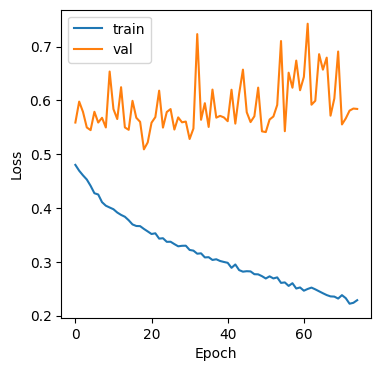

In [93]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot(train_losses, label="train")
ax.plot(val_losses, label="val")
ax.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

The model can train itself - but we are currently not providing useful inputs, and it is therefore overfitting.

Gradient descent will be very unstable as the batch size equals 1.

The U-net was reduced in size dramatically to fit on the GPU.

Memory usage sits at only 210MiB - I believe this is largely attributed to the downscaled data.